# 1. 데이터 불러오기

### 분석하고자 하는 데이터 로드하기 

여기서는 네이버 영화 리뷰 데이터 활용하여 리뷰가 긍정인지 부정인지 판별하는 모델을 만들고자 함

In [1]:
import requests
import pandas as pd
import warnings

warnings.filterwarnings(action='ignore') 

In [2]:
res = requests.get('https://github.com/e9t/nsmc/raw/master/ratings_train.txt')
with open('nsmc_train.csv', 'wb') as f:
    f.write(res.content)

In [2]:
nsmc = pd.read_csv('nsmc_train.csv', sep='\t')
nsmc.dropna(inplace = True)
nsmc.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 한국어 분석을 진행하기 위하여 형태소 단위의 토큰화 기법을 사용하여야 함.

# 2. 형태소 분석기 만들기 - 지도학습

Konlpy package 사이트 : 
https://konlpy-ko.readthedocs.io/ko/v0.4.3/ 

## Konlpy 패키지에서 사용할 수 있는 한국어 형태소 분석기는 다음과 같다.
* komoran
* kkma
* Mecab
* Twitter
* Hannanum

## 딥러닝 기반 형태소 분석기
* stanfordnlp

## 윈도우에서 사용 불가능한 모델
* khaiii

khaiii의 경우 사용하기 위해서 Colab을 활용하는 것이 좋다. 이때 사용하기 위한 코드는 khaiii 사용법이라는 ipynb 파일로 제공할 예정이다.

In [4]:
from konlpy.tag import Hannanum, Kkma, Komoran, Mecab, Twitter

def get_tokenizer(token_name):
    if token_name == 'Komoran':
        tokenizer = Komoran()
        
    elif token_name == 'Kkma':
        tokenizer = Kkma()
        
    elif token_name == 'Mecab': # window 실행 어려움
        tokenizer = Mecab()
    
    elif token_name == 'Twitter':
        tokenizer = Twitter()
        
    elif token_name == 'Hannanum':
        tokenizer = Hannanum()
    else:
        tokenizer = print('Tokenizer의 명칭을 제대로 확인해 주세요')
    return tokenizer

### Konlpy에서 제공하는 형태소 분석기 활용 함수 

#### 공통으로 들어있는 함수 (자주 사용하는 함수만 사용)
* morphs / 형태소 분석 후 형태소 전체 추출
* nouns / 형태소 분석 후 명사인 형태소만 추출
* pos / 형태소 분석 후 품사까지 같이 제공


In [5]:
token = get_tokenizer('Hannanum')
token.morphs('안녕하세요. 저는 지금 한국어 임베딩 스터디를 듣고 있습니다.')

['안녕',
 '하',
 '세',
 '요',
 '.',
 '저',
 '는',
 '지금',
 '한국어',
 '임베딩',
 '스터디',
 '를',
 '듣',
 '고',
 '있',
 '습니다',
 '.']

In [6]:
token.nouns('안녕하세요. 저는 지금 한국어 임베딩 스터디를 듣고 있습니다.')

['안녕', '저', '한국어', '임베딩', '스터디']

In [7]:
token.pos('안녕하세요. 저는 지금 한국어 임베딩 스터디를 듣고 있습니다.')

[('안녕', 'N'),
 ('하', 'X'),
 ('세', 'E'),
 ('요', 'J'),
 ('.', 'S'),
 ('저', 'N'),
 ('는', 'J'),
 ('지금', 'M'),
 ('한국어', 'N'),
 ('임베딩', 'N'),
 ('스터디', 'N'),
 ('를', 'J'),
 ('듣', 'P'),
 ('고', 'E'),
 ('있', 'P'),
 ('습니다', 'E'),
 ('.', 'S')]

### 함수 만들어 보기

In [8]:
def token(word, tokenizers, para):

    token = get_tokenizer(tokenizers)
    
    if para == 'morphs' :
        return token.morphs(word)
    
    elif para == 'nouns':
        return token.nouns(word)
    
    elif para == 'pos':
        return token.pos(word)
    
    else:
        return print('제대로된 인자를 입력해 주세요')

In [9]:
token('안녕하세요. 저는 지금 한국어 임베딩 스터디를 듣고 있습니다.', 'Kkma', 'pos')

[('안녕', 'NNG'),
 ('하', 'XSV'),
 ('세요', 'EFN'),
 ('.', 'SF'),
 ('저', 'NP'),
 ('는', 'JX'),
 ('지금', 'MAG'),
 ('한국어', 'NNG'),
 ('임', 'NNG'),
 ('베', 'NNG'),
 ('딩', 'UN'),
 ('스터디', 'NNG'),
 ('를', 'JKO'),
 ('듣', 'VV'),
 ('고', 'ECE'),
 ('있', 'VXV'),
 ('습니다', 'EFN'),
 ('.', 'SF')]

In [9]:
token('아버지가방에들어가신다', 'Kkma', 'pos')

[('아버지', 'NNG'),
 ('가방', 'NNG'),
 ('에', 'JKM'),
 ('들어가', 'VV'),
 ('시', 'EPH'),
 ('ㄴ다', 'EFN')]

In [10]:
token('안녕하세요. 저는 지금 한국어 임베딩 스터디를 듣고 있습니다.', 'Kkma', 'nouns')

['안녕', '저', '한국어', '임', '임베딩', '베', '딩', '스터디']

In [11]:
token('안녕하세요. 저는 지금 한국어 임베딩 스터디를 듣고 있습니다.', 'Kkma', 'morphs')

['안녕',
 '하',
 '세요',
 '.',
 '저',
 '는',
 '지금',
 '한국어',
 '임',
 '베',
 '딩',
 '스터디',
 '를',
 '듣',
 '고',
 '있',
 '습니다',
 '.']

#### 위의 내용을 참고하여 문장을 입력했을 때 명사가 아닌 것만 출력되게 하는 코드를 작성해 보세요

In [10]:
###
def not_N(text,tokenizer):
    token = get_tokenizer(tokenizer)
    for i,j in token.pos(text) :
        if j[0] != 'N':
            print(i)

In [11]:
not_N('아버지가 방에 들어가신다', 'Hannanum')

가
에
들
어
가
시ㄴ다


### Khaiii 사용하기 

제공된 Khaiii활용.ipynb 파일을 Colab에 올려 실행하면 된다.

### Stanford NLP 사용하기

Stanford NLP란 딥러닝 기반 형태소 분석 라이브러리이다. 

스탠포드 대학 연구팀이 개발 

의존성 분석 (단어가 특정 단어에 의존되는지에 대한 분석)을 지원한다. 

In [ ]:
!conda install pytorch-cpu torchvision-cpu -c pytorch

In [48]:
!pip install stanfordnlp

  Using cached https://files.pythonhosted.org/packages/41/bf/5d2898febb6e993fcccd90484cba3c46353658511a41430012e901824e94/stanfordnlp-0.2.0-py3-none-any.whl


In [12]:
import stanfordnlp
stanfordnlp.download('ko_gsd')

nlp = stanfordnlp.Pipeline(lang='ko', treebank='ko_gsd')

Use device: gpu
---
Loading: tokenize
With settings: 
{'model_path': 'C:\\Users\\hyoun\\stanfordnlp_resources\\ko_gsd_models\\ko_gsd_tokenizer.pt', 'lang': 'ko', 'shorthand': 'ko_gsd', 'mode': 'predict'}
---
Loading: pos
With settings: 
{'model_path': 'C:\\Users\\hyoun\\stanfordnlp_resources\\ko_gsd_models\\ko_gsd_tagger.pt', 'pretrain_path': 'C:\\Users\\hyoun\\stanfordnlp_resources\\ko_gsd_models\\ko_gsd.pretrain.pt', 'lang': 'ko', 'shorthand': 'ko_gsd', 'mode': 'predict'}
---
Loading: lemma
With settings: 
{'model_path': 'C:\\Users\\hyoun\\stanfordnlp_resources\\ko_gsd_models\\ko_gsd_lemmatizer.pt', 'lang': 'ko', 'shorthand': 'ko_gsd', 'mode': 'predict'}
Building an attentional Seq2Seq model...
Using a Bi-LSTM encoder
Using soft attention for LSTM.
Finetune all embeddings.
[Running seq2seq lemmatizer with edit classifier]
---
Loading: depparse
With settings: 
{'model_path': 'C:\\Users\\hyoun\\stanfordnlp_resources\\ko_gsd_models\\ko_gsd_parser.pt', 'pretrain_path': 'C:\\Users\\hyoun\

In [13]:
text = '저는 지금 한국어 임베딩 스터디를 듣고 있습니다.'
doc = nlp(text)
doc

In [14]:
doc.sentences[0].print_dependencies()

('저는', '6', 'nsubj')
('지금', '6', 'advmod')
('한국어', '6', 'obj')
('임베딩', '3', 'flat')
('스터디를', '3', 'flat')
('듣고', '0', 'root')
('있습니다', '6', 'flat')
('.', '7', 'punct')


In [56]:
# text = 형태소 lemma 단어의 어원 upos = 품사, governor = 의존단어 위치
doc.sentences[0].words

[<Word index=1;text=저는;lemma=저+는;upos=PRON;xpos=VV+ETM;feats=_;governor=6;dependency_relation=nsubj>,
 <Word index=2;text=지금;lemma=지금;upos=ADV;xpos=MAG;feats=_;governor=6;dependency_relation=advmod>,
 <Word index=3;text=한국어;lemma=한국어;upos=NOUN;xpos=NNP;feats=_;governor=6;dependency_relation=obj>,
 <Word index=4;text=임베딩;lemma=임베딩;upos=NOUN;xpos=NNG;feats=_;governor=3;dependency_relation=flat>,
 <Word index=5;text=스터디를;lemma=스터디+를;upos=NOUN;xpos=NNG+JKO;feats=_;governor=3;dependency_relation=flat>,
 <Word index=6;text=듣고;lemma=듣+고;upos=VERB;xpos=VV+EC;feats=_;governor=0;dependency_relation=root>,
 <Word index=7;text=있습니다;lemma=있+습니다;upos=VERB;xpos=VX+EF;feats=_;governor=6;dependency_relation=flat>,
 <Word index=8;text=.;lemma=.;upos=PUNCT;xpos=SF;feats=_;governor=7;dependency_relation=punct>]

In [57]:
for word in doc.sentences[0].words:
    print(word.lemma.split('+'))
    print(word.xpos.split('+'))

['저', '는']
['VV', 'ETM']
['지금']
['MAG']
['한국어']
['NNP']
['임베딩']
['NNG']
['스터디', '를']
['NNG', 'JKO']
['듣', '고']
['VV', 'EC']
['있', '습니다']
['VX', 'EF']
['.']
['SF']


In [59]:
for word in doc.sentences[0].words:
    print(list(zip(word.lemma.split('+'), word.xpos.split('+'))))

[('저', 'VV'), ('는', 'ETM')]
[('지금', 'MAG')]
[('한국어', 'NNP')]
[('임베딩', 'NNG')]
[('스터디', 'NNG'), ('를', 'JKO')]
[('듣', 'VV'), ('고', 'EC')]
[('있', 'VX'), ('습니다', 'EF')]
[('.', 'SF')]


In [ ]:
# 코드 수정해서 명사만 출력하는 코드 만들기


In [15]:
# 명사만 추출하는 함수 만들기
def extract_noun(text):
    doc = nlp(text)
    for size in range(len(doc.sentences)):
        for word in doc.sentences[size].words:
            for i,k in list(zip(word.lemma.split('+'), word.xpos.split('+'))):
                if k.startswith('N'):
                    yield i

In [16]:
list(extract_noun(nsmc['document'][0]))

['아', '더빙', '진짜', '목소리']

In [17]:
nsmc['document'][0]

'아 더빙.. 진짜 짜증나네요 목소리'

## 형태소 분석기 만들기 - 비지도학습

### soynlp 

자세한 설명 https://datascienceschool.net/view-notebook/31eaecec4187428a8dfcab5f686bda8b/ 참조 

http://git.ajou.ac.kr/open-source-2018-spring/python_Korean_NLP/tree/master


In [72]:
!pip install soynlp

In [1]:
from soynlp import DoublespaceLineCorpus

# 문서 단위 말뭉치 생성 
corpus = DoublespaceLineCorpus("2016-10-20.txt")
len(corpus)  # 문서의 갯수

30091

In [2]:
# 앞 5개의 문서 인쇄
i = 0
for d in corpus:
    print(i, d)
    i += 1
    if i > 4:
        break

0 
1 19  1990  52 1 22
2 오패산터널 총격전 용의자 검거 서울 연합뉴스 경찰 관계자들이 19일 오후 서울 강북구 오패산 터널 인근에서 사제 총기를 발사해 경찰을 살해한 용의자 성모씨를 검거하고 있다 성씨는 검거 당시 서바이벌 게임에서 쓰는 방탄조끼에 헬멧까지 착용한 상태였다 독자제공 영상 캡처 연합뉴스  서울 연합뉴스 김은경 기자 사제 총기로 경찰을 살해한 범인 성모 46 씨는 주도면밀했다  경찰에 따르면 성씨는 19일 오후 강북경찰서 인근 부동산 업소 밖에서 부동산업자 이모 67 씨가 나오기를 기다렸다 이씨와는 평소에도 말다툼을 자주 한 것으로 알려졌다  이씨가 나와 걷기 시작하자 성씨는 따라가면서 미리 준비해온 사제 총기를 이씨에게 발사했다 총알이 빗나가면서 이씨는 도망갔다 그 빗나간 총알은 지나가던 행인 71 씨의 배를 스쳤다  성씨는 강북서 인근 치킨집까지 이씨 뒤를 쫓으며 실랑이하다 쓰러뜨린 후 총기와 함께 가져온 망치로 이씨 머리를 때렸다  이 과정에서 오후 6시 20분께 강북구 번동 길 위에서 사람들이 싸우고 있다 총소리가 났다 는 등의 신고가 여러건 들어왔다  5분 후에 성씨의 전자발찌가 훼손됐다는 신고가 보호관찰소 시스템을 통해 들어왔다 성범죄자로 전자발찌를 차고 있던 성씨는 부엌칼로 직접 자신의 발찌를 끊었다  용의자 소지 사제총기 2정 서울 연합뉴스 임헌정 기자 서울 시내에서 폭행 용의자가 현장 조사를 벌이던 경찰관에게 사제총기를 발사해 경찰관이 숨졌다 19일 오후 6시28분 강북구 번동에서 둔기로 맞았다 는 폭행 피해 신고가 접수돼 현장에서 조사하던 강북경찰서 번동파출소 소속 김모 54 경위가 폭행 용의자 성모 45 씨가 쏜 사제총기에 맞고 쓰러진 뒤 병원에 옮겨졌으나 숨졌다 사진은 용의자가 소지한 사제총기  신고를 받고 번동파출소에서 김창호 54 경위 등 경찰들이 오후 6시 29분께 현장으로 출동했다 성씨는 그사이 부동산 앞에 놓아뒀던 가방을 챙겨 오패산 쪽으로 도망간 후였다  김 경위는 오패산 터널 입구 오른쪽의 급경

In [3]:
# 문장 단위 말뭉치 생성 
corpus = DoublespaceLineCorpus("2016-10-20.txt", iter_sent=True)
len(corpus)  # 문장의 갯수

223357

In [4]:
# 앞 5개의 문장 인쇄
i = 0
for d in corpus:
    print(i, d)
    i += 1
    if i > 4:
        break

0 19
1 1990
2 52 1 22
3 오패산터널 총격전 용의자 검거 서울 연합뉴스 경찰 관계자들이 19일 오후 서울 강북구 오패산 터널 인근에서 사제 총기를 발사해 경찰을 살해한 용의자 성모씨를 검거하고 있다 성씨는 검거 당시 서바이벌 게임에서 쓰는 방탄조끼에 헬멧까지 착용한 상태였다 독자제공 영상 캡처 연합뉴스
4 서울 연합뉴스 김은경 기자 사제 총기로 경찰을 살해한 범인 성모 46 씨는 주도면밀했다


In [5]:
%%time
from soynlp.word import WordExtractor

word_extractor = WordExtractor()
word_extractor.train(corpus)

training was done. used memory 0.734 Gbse memory 0.801 Gb
Wall time: 46.1 s


In [6]:
word_score = word_extractor.extract()

all cohesion probabilities was computed. # words = 223348
all branching entropies was computed # words = 360721
all accessor variety was computed # words = 360721


### Cohesion

![title](cohesion.png)

In [7]:
word_score["연합"].cohesion_forward

0.1943363253634125

In [8]:
word_score["연합뉴"].cohesion_forward

0.43154839105434084

In [9]:
word_score["연합뉴스"].cohesion_forward

0.5710254410737682

In [10]:
word_score["연합뉴스는"].cohesion_forward

0.1535595043355021

![title](branching.png)

In [11]:
word_score["연합"].right_branching_entropy

0.42721236711742844

In [12]:
word_score["연합뉴"].right_branching_entropy

-0.0

![title](L_token.png)

In [14]:
from soynlp.tokenizer import LTokenizer

scores = {word:score.cohesion_forward for word, score in word_score.items()}
l_tokenizer = LTokenizer(scores=scores)

l_tokenizer.tokenize("아버지가방에들어가신다.", flatten=False)

[('아버지가', '방에들어가신다.')]

In [15]:
l_tokenizer.tokenize("아버지가 방에 들어가신다.", flatten=False)

[('아버지가', ''), ('방에', ''), ('들어', '가신다.')]

![title](max_token.png)

In [16]:
from soynlp.tokenizer import MaxScoreTokenizer

maxscore_tokenizer = MaxScoreTokenizer(scores=scores)
maxscore_tokenizer.tokenize("아버지가방에들어가신다.")

['아버지가', '방에', '들어', '가신다.']

In [17]:
maxscore_tokenizer.tokenize("아버지가 방에 들어가신다.")

['아버지가', '방에', '들어', '가신다.']

## Sentence Piece

구글에서 BPE 알고리즘과 Unigram Language Model Tokenizer를 구현한 모델

BPE란 무엇인지에 대한 자료 https://wikidocs.net/22592

* BPE는 글자 단위에서 점차적으로 단어 집합을 만들어 내는 방식 

* 훈련 데이터 내에 있는 모든 글자 또는 유니코드 단위로 집합 만들고 여러 유니그램 하나로 통합 - 즉 패턴을 통해 해당 단어에 대하여 찾아낸다 생각하면 된다.

* 실제로 이번 고어번역기 모델에 적용한 결과 전과 대비해 엄청나게 좋은 성능을 보여주었음 단 이때 데이터에 대하여 충분한 전처리와 추출작업 등을 먼저 진행하여야 했다. 

### 사용법 

1. 토큰화를 진행하고자 하는 데이터에 대한 파일을 만든다. 

2. SentencePieceTrainer의 train 기능을 활용 자신이 원하는 oov 및 pad, unk 등 옵션을 설정하고 토큰을 몇개로 설정할 것인지, 만들어진 모델의 이름을 어떻게 저장할 것인지를 설정한다. 

3. 만들어진 모델을 불러온다. 

4. EncodeAsPieces 함수를 활용 토큰화를 진행한다.

In [ ]:
! pip install sentencepiece

In [3]:
# 네이버 댓글 자료 만들기.
with open('naver.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(nsmc['document']))

In [13]:
# txt 파일을 불러와 token 만드는 작업 시행, -1은 사용하지 않겠다는 의미 
# 단어의 개수는 5000개를 사용할 것임 
import sentencepiece as spm
spm.SentencePieceTrainer.Train('--pad_id=0 --bos_id=-1 --eos_id=-1 --unk_id=1 --input=naver.txt --model_prefix=naver --vocab_size=5000 --model_type=unigram')

True

In [4]:
with open('naver.vocab', encoding='utf-8') as f:
    Vo = [doc.strip().split("\t") for doc in f]

# w[0]: Padding   
# w[1]: Unkown
word2idx = {w[0]: i for i, w in enumerate(Vo)}
word2idx

{'<pad>': 0,
 '<unk>': 1,
 '▁': 2,
 '.': 3,
 '이': 4,
 '..': 5,
 '가': 6,
 '▁영화': 7,
 '의': 8,
 '...': 9,
 '도': 10,
 '는': 11,
 '을': 12,
 '고': 13,
 '에': 14,
 ',': 15,
 '다': 16,
 '은': 17,
 '지': 18,
 '한': 19,
 '?': 20,
 '만': 21,
 '로': 22,
 '를': 23,
 '게': 24,
 '나': 25,
 '▁너무': 26,
 '영화': 27,
 '!': 28,
 '▁이': 29,
 '▁정말': 30,
 '리': 31,
 '어': 32,
 '아': 33,
 '기': 34,
 '인': 35,
 '과': 36,
 '하고': 37,
 '라': 38,
 '▁진짜': 39,
 '~': 40,
 '서': 41,
 '네': 42,
 '해': 43,
 '으로': 44,
 '점': 45,
 '요': 46,
 '자': 47,
 '▁안': 48,
 '▁그': 49,
 '에서': 50,
 '스': 51,
 '들': 52,
 '네요': 53,
 '와': 54,
 '▁아': 55,
 '▁잘': 56,
 '수': 57,
 '음': 58,
 '면': 59,
 '하는': 60,
 '거': 61,
 '▁왜': 62,
 '▁수': 63,
 '▁다': 64,
 '사': 65,
 '....': 66,
 '▁1': 67,
 '하': 68,
 '!!': 69,
 '▁이런': 70,
 '시': 71,
 '▁더': 72,
 '니': 73,
 '대': 74,
 '▁본': 75,
 '함': 76,
 '지만': 77,
 '야': 78,
 '하다': 79,
 '하게': 80,
 '보': 81,
 '일': 82,
 '▁그냥': 83,
 '우': 84,
 '▁드라마': 85,
 '진': 86,
 '이다': 87,
 '주': 88,
 '정': 89,
 '여': 90,
 '드': 91,
 '할': 92,
 '는데': 93,
 '▁내': 94,
 '미': 9

## 준단어 토큰화하기

In [5]:
import sentencepiece as spm
from sentencepiece import SentencePieceProcessor
sp = spm.SentencePieceProcessor()
sp.Load('naver.model') 

sp.encode_as_pieces(nsmc.loc[0, 'document'])

['▁아', '▁더빙', '..', '▁진짜', '▁짜증나', '네요', '▁목소리']

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000, lowercase=False, tokenizer=sp.encode_as_pieces)
tdm = cv.fit_transform(nsmc['document'])

In [7]:
# train, test 분리
x_train = tdm[:1600]
x_test = tdm[1600:]
y_train = nsmc['label'][:1600]
y_test = nsmc['label'][1600:]

# NLP 분석 (Keras의 Dense Layer 활용) 

1. sentencepiece 활용 할때

2. stanfordnlp 사용할 때 

# SentencePiece 사용

In [8]:
import tensorflow as tf 

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(1, input_shape=(5000,), activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
model.fit(x_train, y_train, epochs=10)

Train on 1600 samples
Epoch 1/10
1600/1600 [==============================] - 1s 473us/sample - loss: 0.6874 - accuracy: 0.5569
Epoch 2/10
1600/1600 [==============================] - 0s 144us/sample - loss: 0.6572 - accuracy: 0.7513
Epoch 3/10
1600/1600 [==============================] - 0s 143us/sample - loss: 0.6308 - accuracy: 0.8269
Epoch 4/10
1600/1600 [==============================] - 0s 142us/sample - loss: 0.6063 - accuracy: 0.8644
Epoch 5/10
1600/1600 [==============================] - 0s 139us/sample - loss: 0.5841 - accuracy: 0.8831
Epoch 6/10
1600/1600 [==============================] - 0s 145us/sample - loss: 0.5637 - accuracy: 0.8931
Epoch 7/10
1600/1600 [==============================] - 0s 145us/sample - loss: 0.5449 - accuracy: 0.9038
Epoch 8/10
1600/1600 [==============================] - 0s 143us/sample - loss: 0.5273 - accuracy: 0.9100
Epoch 9/10
1600/1600 [==============================] - 0s 145us/sample - loss: 0.5111 - accuracy: 0.9137
Epoch 10/10
1600/1600 [=

In [10]:
model.evaluate(x_test, y_test)

148395/148395 [==============================] - 17s 114us/sample - loss: 0.6065 - accuracy: 0.7341


[0.6064644928593701, 0.73412174]

In [11]:
weight, bias = model.trainable_weights

In [12]:
word_weight = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '가중치': weight.numpy().flat
})

In [13]:
word_weight.sort_values('가중치').head()

,단어,가중치
2891,냐,-0.257413
1428,▁아까운,-0.238297
3586,분,-0.212414
235,▁0,-0.206012
1752,▁욕,-0.205945


In [14]:
word_weight.sort_values('가중치').tail()

,단어,가중치
2058,▁정말,0.215537
2262,▁최고,0.215565
922,▁명작,0.220116
1997,▁재밌게,0.233178
2264,▁최고의,0.248644


# stanfordnlp 사용하기

In [15]:
import stanfordnlp

nlp = stanfordnlp.Pipeline(lang='ko', treebank='ko_gsd')

Use device: gpu
---
Loading: tokenize
With settings: 
{'model_path': 'C:\\Users\\hyoun\\stanfordnlp_resources\\ko_gsd_models\\ko_gsd_tokenizer.pt', 'lang': 'ko', 'shorthand': 'ko_gsd', 'mode': 'predict'}
---
Loading: pos
With settings: 
{'model_path': 'C:\\Users\\hyoun\\stanfordnlp_resources\\ko_gsd_models\\ko_gsd_tagger.pt', 'pretrain_path': 'C:\\Users\\hyoun\\stanfordnlp_resources\\ko_gsd_models\\ko_gsd.pretrain.pt', 'lang': 'ko', 'shorthand': 'ko_gsd', 'mode': 'predict'}


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 4.00 GiB total capacity; 1.03 MiB already allocated; 0 bytes free; 997.50 KiB cached)

In [ ]:
content = nsmc['document'][:500]

In [ ]:
def extract_token(text): # 명사추출 함수 
    doc = nlp(text)
    token = []
    for sentence in doc.sentences:
        for word in sentence.words:
            token.append(word.text)
    return token

In [ ]:
extract_token(nsmc.loc[0, 'document'])

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000, tokenizer= extract_token)

tdm = cv.fit_transform(content)

# 코드 작성 중 자꾸 오류가 발생하여 진행하지 못하였음. 이와 비슷한 방식으로 진행하면 된다.

## 이런식으로 댓글이 새로 입력이 되었을 때 해당 댓글이 긍정인지 부정인지에 대하여 판별하는 모델을 만들 수 있음 

## 단 주의해야 하는 점 NLP의 경우 데이터가 어디에 수집되었느냐에 따라 각각의 의미가 달라질 수 있기 때문에 댓글 활용하여 모델을 만들었다면 댓글 분석에만 사용해야한다. 

## TDM을 만들어 분석한것 처럼 TDM자리에 TF-IDF를 만들고 분석을 하면 된다. 

## Seq2Seq등과 같은 다른 기법의 경우 이와 다른 방법을 활용한다. - 궁금한 분께서는 개인적으로 이야기해주세요.

## RNN, LSTM 등을 활용하여 분석을 진행할 수 있다 이때는 다른 방법을 사용하는데 순서는 다음과 같다.
1. 단어 사전을 제작한다. 


2. 문장에 대하여 Token화를 진행한 후 해당 단어에 대하여 단어사전에 등록된 숫자로 변경한다. 


3. 변환된 값을 Embedding에 뿌려 값을 만들고 작업을 진행한다 


4. RNN, LSTM, 양방향 RNN 등을 삽입하거나 Flatten하여 작업을 진행한다. 

## LDA, LSA 코드

In [16]:
df = pd.read_csv('wikipedia-movie-plots.zip')
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [17]:
plot = df['Plot']

In [18]:
from sklearn.model_selection import train_test_split

plot_train, plot_test = train_test_split(plot, test_size=.2, random_state=1234)

### TDM

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
cv = CountVectorizer(stop_words='english', max_features=2000)

In [21]:
x_train = cv.fit_transform(plot_train)
x_test = cv.transform(plot_test)

## gensim을 이용한 LDA

### gensim 설치

아나콘다에서 설치

In [12]:
!conda install -y gensim

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\hyoun\Anaconda3

  added / updated specs:
    - gensim


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    boto3-1.10.19              |             py_0          91 KB
    botocore-1.13.19           |             py_0         3.3 MB
    bz2file-0.98               |           py37_1          14 KB
    gensim-3.8.0               |   py37hf9181ef_0        18.4 MB
    jmespath-0.9.4             |             py_0          22 KB
    s3transfer-0.2.1           |           py37_0          99 KB
    smart_open-1.9.0           |             py_0          59 KB
    ------------------------------------------------------------
                                           Total:        22.0 MB

The following NEW packages will be INSTALLED:

  boto3              pkgs/main/noarch::boto3-1.10.19-py_0
  botocore    

아나콘다가 아닐 경우

!pip install gensim

### TDM을 gensim의 Corpus 포맷으로 변환

In [22]:
from gensim.matutils import Sparse2Corpus

In [23]:
corpus = Sparse2Corpus(x_train.T) # x_train.T에서 .T는 전치(transpose: 행과 열을 뒤집는 것)
# 행에 단어 컬럼에 문장을 넣어야 함. (문장을 묶어 주제로 만들기 위해 컬럼으로 들어가야함.)
# gensim 패키지는 tdm을 넣어주면 된당. 
# corpus 포맷으로 만들어 주어야 실행된다. 
# corpus 형태는 행에 단어 열에 주제에 대한 정보 

In [24]:
id2word = dict(enumerate(cv.get_feature_names()))

### LDA 분석 실시

In [25]:
from gensim.models.ldamodel import LdaModel

In [26]:
models = {}
# 주제가 몇개 있는지 모르기 때문에 하이퍼 파라미터 설정 
for num_topics in [5, 10, 50]:
    models[num_topics] = LdaModel(
        corpus=corpus,
        num_topics=num_topics,
        passes=3, # passes와 iterations는 연산 횟수를 의미하는데 많이 하면 할 수 록 성능 좋아짐. # passes 전체 데이터를 몇번 훑을지, epoch와 같음  
        iterations=100, 
        id2word=id2word,
        random_state=123)

In [16]:
# Monte carlo 기법? 

# 원의 반지름은 어케구하나?
## 확률을 추정한 다음 시행을 무한이 많이 하여 수렴하게 하는 기법 이를 통해 미지수를 추정하는 방법임 

# 파이 추정하는 방법 
# LDA도 이와 같은 기법 활용해서 근사해서 계산함. 
import numpy as np

x = np.random.uniform(-1,1,10000000)
y = np.random.uniform(-1,1,10000000)

(x ** 2 + y ** 2 <= 1).mean()*4

3.141602

### Perplexity

단어의 분포가 얼마나 정확한지에 대하여 판단할때 사용하는 수치

수치가 커지면 단어 복잡도가 많이 크다는 의미임. 

0에 가까울 수록 더 좋다.

In [17]:
test_corpus = Sparse2Corpus(x_test.T)

In [18]:
models

{5: <gensim.models.ldamodel.LdaModel at 0x20d3964a148>,
 10: <gensim.models.ldamodel.LdaModel at 0x20d32a89e48>,
 50: <gensim.models.ldamodel.LdaModel at 0x20d39436748>}

In [19]:
for num_topics in models:
    print(num_topics, models[num_topics].log_perplexity(test_corpus))

5 -7.108070179948764
10 -7.105554355511369
50 -7.190093588127462


In [20]:
# 실제 perplexity 구하기

np.exp(7.105554355511369) # 1218단어 마다 1개씩 100% 맞출 수 있다. 
# 다음단어 추론할 때 1/1218의 확률이다.

1218.717500269996

### 주제 보기

In [21]:
models[10].show_topics()

[(0,
  '0.008*"war" + 0.008*"king" + 0.006*"ship" + 0.006*"men" + 0.006*"group" + 0.006*"army" + 0.006*"world" + 0.005*"killed" + 0.005*"escape" + 0.005*"captain"'),
 (1,
  '0.019*"tom" + 0.017*"house" + 0.010*"jerry" + 0.009*"body" + 0.009*"night" + 0.009*"room" + 0.008*"tells" + 0.008*"home" + 0.008*"finds" + 0.007*"away"'),
 (2,
  '0.021*"father" + 0.021*"love" + 0.017*"family" + 0.013*"mother" + 0.012*"son" + 0.011*"daughter" + 0.009*"life" + 0.009*"marriage" + 0.009*"house" + 0.008*"wife"'),
 (3,
  '0.018*"police" + 0.009*"car" + 0.007*"sam" + 0.007*"killed" + 0.007*"kill" + 0.007*"man" + 0.006*"escape" + 0.006*"gun" + 0.006*"jimmy" + 0.005*"later"'),
 (4,
  '0.010*"school" + 0.010*"new" + 0.008*"time" + 0.007*"film" + 0.007*"day" + 0.007*"home" + 0.006*"tells" + 0.006*"friends" + 0.006*"life" + 0.005*"father"'),
 (5,
  '0.055*"frank" + 0.054*"charlie" + 0.046*"johnny" + 0.041*"nick" + 0.038*"raja" + 0.028*"helen" + 0.019*"linda" + 0.018*"jackie" + 0.017*"anand" + 0.014*"kelly"'),

In [22]:
models[10].show_topic(0)

[('war', 0.007855945),
 ('king', 0.0077317017),
 ('ship', 0.006199054),
 ('men', 0.006128602),
 ('group', 0.0057548573),
 ('army', 0.0055977134),
 ('world', 0.005520351),
 ('killed', 0.0051553347),
 ('escape', 0.0049308473),
 ('captain', 0.0049248543)]

### 문서의 주제

In [23]:
row = x_test[0]
doc = list(zip(row.indices, row.data))
doc

[(9, 1),
 (30, 1),
 (78, 1),
 (110, 1),
 (112, 1),
 (129, 2),
 (131, 2),
 (189, 1),
 (260, 1),
 (261, 1),
 (331, 2),
 (347, 1),
 (352, 1),
 (356, 2),
 (413, 2),
 (415, 1),
 (426, 1),
 (434, 1),
 (437, 1),
 (448, 1),
 (476, 1),
 (496, 1),
 (503, 1),
 (534, 1),
 (585, 1),
 (638, 1),
 (644, 2),
 (657, 1),
 (743, 1),
 (767, 1),
 (798, 1),
 (843, 1),
 (907, 5),
 (937, 1),
 (1023, 1),
 (1055, 1),
 (1071, 4),
 (1075, 1),
 (1111, 1),
 (1133, 1),
 (1151, 1),
 (1181, 2),
 (1188, 3),
 (1206, 1),
 (1211, 1),
 (1215, 1),
 (1235, 1),
 (1244, 1),
 (1248, 1),
 (1267, 2),
 (1277, 1),
 (1293, 1),
 (1399, 1),
 (1485, 1),
 (1495, 1),
 (1536, 1),
 (1545, 5),
 (1551, 1),
 (1573, 1),
 (1621, 4),
 (1668, 2),
 (1671, 1),
 (1744, 1),
 (1844, 1),
 (1867, 1),
 (1884, 1),
 (1971, 1)]

In [24]:
for i, n in doc:
    print(id2word[i], n)

aboard 1
adult 1
animals 1
arrive 1
arrives 1
attack 2
attacks 2
better 1
captain 1
capture 1
circus 2
coast 1
collect 1
comes 2
creature 2
crew 1
cut 1
dangerous 1
dark 1
deal 1
despite 1
died 1
discover 1
drive 1
enter 1
fear 1
feet 2
finally 1
goes 1
group 1
having 1
hoping 1
island 5
joe 1
later 1
like 1
london 4
looking 1
manage 1
master 1
men 1
monster 2
mother 3
names 1
navy 1
nearly 1
note 1
offered 1
officer 1
owner 2
park 1
people 1
public 1
rescues 1
return 1
royal 1
ryan 5
sam 1
sea 1
ship 4
son 2
soon 1
study 1
treasure 1
turns 1
university 1
woman 1


In [25]:
models[10].get_document_topics(doc)

[(0, 0.7228719),
 (2, 0.06179989),
 (3, 0.024760846),
 (8, 0.093357325),
 (9, 0.09183118)]

## Latent Semantic Analysis

In [26]:
from sklearn.decomposition import TruncatedSVD

In [27]:
x = np.matrix([[1,2,3],[2,4,5],[6,8,9]])
u, s, v = np.linalg.svd(x)

In [28]:
x

matrix([[1, 2, 3],
        [2, 4, 5],
        [6, 8, 9]])

In [29]:
np.diag(u)

array([-0.23799094, -0.67025772, -0.08246612])

In [30]:
u

matrix([[-0.23799094, -0.56130663, -0.79265073],
        [-0.43110373, -0.67025772,  0.60407298],
        [-0.87035044,  0.48547858, -0.08246612]])

In [31]:
np.diag(s)

array([[15.44287374,  0.        ,  0.        ],
       [ 0.        ,  1.21329097,  0.        ],
       [ 0.        ,  0.        ,  0.21348477]])

In [32]:
s

array([15.44287374,  1.21329097,  0.21348477])

In [33]:
np.diag(v)

array([-0.40939926,  0.06608843, -0.46739811])

In [34]:
v

matrix([[-0.40939926, -0.59336108, -0.69304752],
        [ 0.83331158,  0.06608843, -0.5488389 ],
        [-0.37146207,  0.80221876, -0.46739811]])

In [35]:
u @ np.diag(s) @ v

matrix([[1., 2., 3.],
        [2., 4., 5.],
        [6., 8., 9.]])

In [36]:
svd = TruncatedSVD(n_components=100, random_state=1234) # 몇 차원으로 줄일지에 대한 이야기 

In [37]:
svd.fit(x_train)

TruncatedSVD(algorithm='randomized', n_components=100, n_iter=5,
             random_state=1234, tol=0.0)

In [38]:
from matplotlib import pyplot

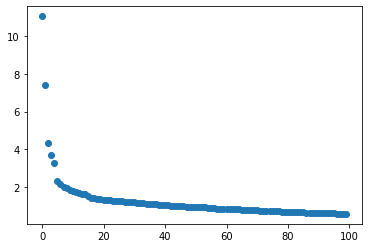

In [39]:
pyplot.plot(svd.explained_variance_, 'o')

In [ ]:
# 해당 차원의 개수일 때 설명하는 정도 

### 차원 축소

In [40]:
x_test.shape

(6978, 2000)

In [41]:
doc_emb = svd.transform(x_test)

In [42]:
doc_emb.shape

(6978, 100)

### 주제 보기

In [43]:
svd.components_.shape

(100, 2000)

In [44]:
loading = pd.DataFrame(svd.components_.T) # components는 svd를 실행한 결과에서 컬럼에 대한 주제확률 의미한다. 이때 모든 값은 양수  
# components_의 값은 열값(여기서는 단어를 의미)을 우리가 지정한 값의 개수만큼으로 늘려 값 변환시킨것. 

In [45]:
loading['word'] = cv.get_feature_names()

In [46]:
i = 0
loading.sort_values(i, ascending=False).loc[:, [i, 'word']].head()
# 0번째 축에 들어간 단어들을 의미한다. 해당 방향으로 바뀌엇음을 의미. 

,0,word
1797,0.190082,tells
636,0.184727,father
850,0.143918,house
838,0.143609,home
1110,0.135895,man


In [47]:
loading

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,word
0,0.017806,-0.005246,0.001069,0.008322,-0.021213,0.011804,0.013197,-0.001181,0.004836,0.009516,...,0.007092,-0.005775,0.003275,0.009648,-0.008887,0.005153,0.001257,-0.008574,0.013057,000
1,0.008293,-0.002052,-0.000980,0.000601,-0.004791,0.001792,0.000145,0.001843,-0.002099,0.002838,...,0.000946,0.000346,-0.001213,0.005679,0.002205,-0.002511,-0.004490,-0.003631,-0.000784,10
2,0.004039,-0.000747,0.000185,0.000269,-0.003508,-0.000539,-0.000865,0.001141,0.000457,0.001699,...,0.001308,-0.000848,-0.000898,0.001111,-0.000551,0.001025,-0.001603,-0.000552,0.001470,100
3,0.004470,-0.001072,-0.000567,-0.001102,-0.002203,0.001230,-0.002135,0.000707,0.000895,-0.002291,...,-0.002663,-0.001319,0.000589,0.004077,-0.002794,0.000912,-0.002016,-0.004333,-0.003633,12
4,0.004495,-0.001154,0.000396,-0.000299,-0.002092,0.003453,-0.001529,0.001102,-0.000213,0.000043,...,0.001843,0.003544,-0.000402,0.000161,0.002282,0.001416,-0.003112,0.002001,0.000053,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.067410,0.016862,-0.012180,-0.017198,0.014854,-0.000783,-0.064824,0.016383,0.015994,-0.002943,...,0.012066,0.030562,0.021192,0.054388,0.039986,-0.031969,-0.011626,0.002342,0.030101,years
1996,0.025387,-0.007917,-0.000599,0.004194,-0.014811,0.046351,-0.034786,0.006689,0.006607,0.003793,...,0.015426,-0.001542,-0.010022,0.019866,0.018368,-0.001909,-0.003628,0.022308,0.002969,york
1997,0.067205,-0.015764,-0.016609,-0.019705,-0.001339,-0.004872,-0.053919,0.032678,0.010115,0.017758,...,-0.084192,0.068043,0.048618,0.009887,-0.116941,-0.072579,0.061190,0.016748,0.170012,young
1998,0.016255,-0.000265,-0.005712,-0.009287,0.014262,-0.010788,-0.007070,0.003775,0.006573,-0.004433,...,0.001490,-0.005062,-0.009501,0.004775,0.001163,-0.014563,0.036915,0.010742,0.005654,younger
